<a href="https://colab.research.google.com/github/tirals88/pytorch-drl/blob/main/DRL_Chap3_2_CartPole_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'PyTorch를 활용한 강화학습/심층강화학습 실전입문' 책 스터디 내용을 Google Colab으로 정리하여 올립니다.

Github 예제 코드 주소 : 'https://github.com/wikibook/pytorch-drl'

PyTorch를 활용한 강화학습/심층강화학습 실전입문

https://wikibook.co.kr/pytorch-drl/

### ***가상환경 구현 및 함수 수정***

In [ ]:
# matplotlib -downgrade

!pip install matplotlib==3.4.2
#호출 후 재시작

In [ ]:
!apt update
!apt install -y xvfb #server install
import sys

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
  !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
  %pip install -U tf-agents pyvirtualdisplay
  %pip install -U gym>=0.21.0
  %pip install -U gym[box2d,atari, accept-rom-license]

!xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
37 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x

ERROR: Operation cancelled by user
ERROR: Invalid requirement: 'gym[box2d,atari,'


### ***display_frames_as_gif 함수 정의***

In [1]:
# 구현에 사용할 패키지 임포트
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [29]:
# 애니메이션을 만드는 함수
# 참고 URL : https://github.com/patrickmineault/xcorr-notebooks/blob/master/notebooks/Render%20OpenAI%20gym%20as%20GIF.ipynb
#!pip install JSAnimation
#from JSAnimation.IPython_display import display_animations # error 발생으로 사용하지 않음
from matplotlib import animation
from IPython.display import display

#새로 정의한 display_animtaion 함수

from IPython.display import HTML

In [30]:
def display_animation(anim):
  return HTML(anim.to_jshtml())

In [31]:
def display_frames_as_gif(frames):
  """
  Displays a list of frames as a gif, with controls
  """
  plt.figure(figsize=(frames[0].shape[1]/48.0, frames[0].shape[0]/48.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')

  def animate(i):
    patch.set_data(frames[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=20)

  anim.save('movie_cartpole.mp4') #애니메이션을 저장하는 부분
  display(display_animation(anim)) #수정된 부분

In [4]:
try:
  import pyvirtualdisplay
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

except ImportError:
  pass

In [5]:
env = gym.make('CartPole-v1')
obs=env.reset()

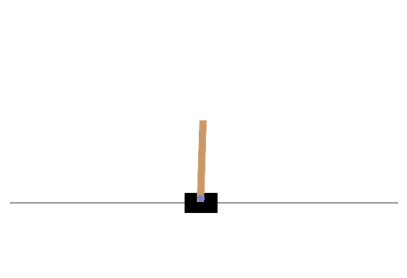

In [6]:
def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img=env.render(mode='rgb_array')
  plt.imshow(img)
  plt.axis('off')
  return img

plot_environment(env)
plt.show()

## 3.3 다변수, 연속값 상태를 표형식으로 나타내기

### CartPole 의 상태

이전 장에서 다뤘던 미로 태스크에서 상태는 에이전트가 어느 칸에 위치했는지를 변수 하나로 나타냈으며 0~8의 단순 이산값이었다. 그러나 역진자 태스크에서는 더 복잡하게 상태가 정의된다.

CartPole 태스크는 observation 변수에 상태를 저장한다. env.step(action)은 게임 환경을 1단계 진행시키는 명령어로 action = 0 일 때 수레를 왼쪽으로 움직이는 것이고 1 일 때 오른쪽으로 움직이는 것에 해당한다.

env.step(action) 은 observation, reward, done, info 라는 4개의 변수를 반환한다. observation은 수레와 봉의 상태를 나타내며 상태는 다시 4개의 변수로 이루어져 있다. 이는 수레의 위치 (-2.4 ~ 2.4), 수레의 속도 (-inf ~ inf), 봉의 각도 (-41.8도 ~ 41.8), 봉의 가속도 (-inf ~ inf)이다.

reward는 즉각보상이며 action을 실행한 후에 수레의 위치가 $\pm2.4$ 범위 안에 있고 봉이 $20.9$도 이상 기울어 있지 않다면 보상 1을 받는다. 반대의 경우, 보상은 0이 된다.

done 은 게임 종료 여부를 나타내며, 200단계를 초과하거나, 보상이 0일 될 때 게임이 종료되어 done 의 값이 True가 된다.

info 는 디버깅 등에 필요한 정보를 담은 변수이다.

observation의 4가지 변수는 모두 연속값으로 이루어져있다. 이를 표형식으로 나타내기 위해 연속값을 이산값으로 변환해야 한다.

예를 들어 수레의 위치를 6개의 구간의 이산값으로 변환한다면 -2.4 / -1.6 / -0.8 / 0 / 0.8 / 1.6 / 2.4 로 구간을 나누어 0 ~ 5의 값을 반환할 수 있다. 그러나 이 양 끝 범위를 벗어날 가능성도 있으므로 -Inf ~ -1.6 을 0으로, 1.6 ~ Inf 를 5로 정의한다.

다른 변수도 6개의 구간을 갖는 이산변수로 변환한다. 그러면 변수의 가짓수가 $6^{4} = 1296$개로 수레의 상태를 나타낼 수 있다.

CartPole 에서 취할 수 있는 행동은 수레를 오른쪽이나 왼쪽으로 밀기 두 가지다. 이후 수레는 가속도를 부여받는다. 각 상태변수를 6개의 구간을 갖는 이산변수로 변환하면 CartPole의 Q함수는 1296행 2열로 된 표로 나타낼 수 있다.

### 상태의 이산변수 변환 구현



```
ENV = 'CartPole-v0' # 태스크 이름
NUM_DIZITIZED = 6 # 각 상태를 이산변수로 변환할 구간 수

env = gym.make(ENV) # 실행할 태스크 설정
observation = env.reset() # 환경 초기화
```

env.reset()을 호출하면 초기 상태가 반환되므로 이 반환값을 observation 에 저장한다. 그 다음 이 변수의 값을 이산변수로 변환하는 함수를 정의한다.



```
# 이산값으로 만들 구간 계산
def bins(climp_min, climp_max, num):
  '''
  관측된 상태(연속값)을 이산값으로 변환하는 구간을 계산
  '''
  return np.linspace(climp_min, climp_max, num+1)[1:-1]

def digitize_state(observation):
  '''
  관측된 상태(observation 변수)를 이산값으로 변환
  '''
  cart_pos, cart_v, pole_angle, pole_v = observation

  digitized = [
    np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
    np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
    np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)),
    np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))]

  return sum([x * (NUM_DIGITIZED ** i) for i, x in enumerate(digitized)])
    
```

pole_angle 변수의 구간을 -0.5 ~ 0.5 까지 설정한 이유는 단위가 라디안 radian 이기 때문이다.

$0.5rad  = 0.5 \cdot \frac{180}{\pi} \approx 28.65$  약 29도가 된다.

digitize_state 함수의 반환값은 이산값으로 변환한 상태를 나타내는 4개의 변수를 모두 합쳐 0 부터 1295 사이의 값으로 변환한 것이다. NUM_DIGITIZED = 6 이라면 6진수로 계산한다. 만약 digitized = [[1],[2],[3],[4]] 라면 다음과 같이 변환할 수 있다.

$$ 1\cdot 6^{0} + 2\cdot 6^{1} + 3\cdot 6^{2} + 4\cdot 6^{3} = 985$$
이는 digitized  = $(\mathbb{Z}_{6})^{4}$ 와 $(0, 1295) \subset \mathbb{Z}$ 두 집합 간의 ***bijection***이 존재하기 때문에 가능하다

In [ ]:
sum([x*(6**i) for i, x in enumerate([np.array([5]),np.array([5]), np.array([5]), np.array([5])])])

array([1295])

In [ ]:
help(enumerate)

#  enumerate is useful for obtaining an indexed list:
#        (0, seq[0]), (1, seq[1]), (2, seq[2]), ...

In [ ]:
help(np.digitize)
# digitize(x, bins, right=False)
#     Return the indices of the bins to which each value in input array belongs.

#     =========  =============  ============================
#     `right`    order of bins  returned index `i` satisfies
#     =========  =============  ============================
#     ``False``  increasing     ``bins[i-1] <= x < bins[i]``
#     ``True``   increasing     ``bins[i-1] < x <= bins[i]``
#     ``False``  decreasing     ``bins[i-1] > x >= bins[i]``
#     ``True``   decreasing     ``bins[i-1] >= x > bins[i]``
#     =========  =============  ============================

#     If values in `x` are beyond the bounds of `bins`, 0 or ``len(bins)`` is
#     returned as appropriate.

In [7]:
ENV = 'CartPole-v1' # 태스크 이름
NUM_DIZITIZED = 6 # 각 상태를 이산변수로 변환할 구간 수

env = gym.make(ENV) # 실행할 태스크 설정
observation = env.reset() # 환경 초기화

## Q러닝 구현

이번 절에서는 CartPole의 수레를 Q러닝으로 제어할 수 있도록 구현할 것이다. 여기서 정책반복이나 Sarsa 알고리즘 대신 Q러닝을 사용하는 이유는 5장에서 소개할 심층강화학습에서 Q러닝을 사용하기 때문이다. 이번 절에서는 OpenAI Gym의 기존 구현과 맞춰 프로그램을 작성해야한다.

In [8]:
# 상수 정의
GAMMA = 0.99 # 시간할인율
ETA = 0.5 # 학습률
MAX_STEPS = 200 # 1에피소드 당 최대 단계 수
NUM_EPISODES = 1000 # 최대 에피소드 수

In [9]:
class Agent:
  '''CartPole 에이전트 역할을 할 클래스, 봉 달린 수레'''

  def __init__(self, num_states, num_actions):
    self.brain = Brain(num_states, num_actions) # 에이전트가 행동을 결정하는 두뇌 역할

  def update_Q_function(self, observation, action, reward, observation_next):
    '''Q함수 수정'''
    self.brain.update_Q_table(
        observation, action, reward, observation_next)

  def get_action(self, observation, step):
    '''행동 결정'''
    action = self.brain.decide_action(observation, step)
    return action

교재 코드와 차이점은 두 곳 존재한다.

우선 교재내의 Environment 클래스 내 run 메소드의 아래 코드는 다음과 같이 출력된다.


```
observation = self.env.reset()

#(array([-0.0431986 , -0.03948765,  0.0466724 ,  0.03621309], dtype=float32),
 {})
```
따라서 다음과 같이 수정을 하였다. 이는 gym 패키지의 버전차이 문제로 보인다.
```
observation = self.env.reset()[0]
```

같은 메소드 내에 수정된 코드가 한 줄 더 있다.
```
observation_next, _, done, _, _ = self.env.step(action)
```

교재에서는 env.step(action)의 return 값이 4개로 설명되어 있지만
```
Help on method step in module gym.wrappers.time_limit:

step(action) method of gym.wrappers.time_limit.TimeLimit instance
    Steps through the environment and if the number of steps elapsed exceeds ``max_episode_steps`` then truncate.
    
    Args:
        action: The environment step action
    
    Returns:
        The environment step ``(observation, reward, terminated, truncated, info)`` with `truncated=True`
        if the number of steps elapsed >= max episode steps
```
truncated 라는 변수가 추가된 것을 볼 수 있다. 이는 gym 클래스 내에 'max_episode_steps'를 지정할 수 있게 되면서 생긴 변수이다. 그러나 해당 교재의 코드는 반복문을 통해 최대 에피소드 관리를 하였고 이 부분을 수정하였다.

----
***matplotlib version downgrade, 가상환경 생성 완료 시 위 수정된 코드 전부 되돌려서 실행***

In [10]:
class Brain:
  '''에이전트의 두뇌 역할을 하는 클래스, Q러닝을 실제 수행'''

  def __init__(self, num_states, num_actions):
    self.num_actions = num_actions # 행동의 가짓수(왼쪽, 오른쪽)를 구함

    # Q테이블을 생성, 행의 수는 상태를 구간수 ^4 (4는 변수의 수)가지 값 중 하나로 변환한 값, 열의 수는 행동의 가짓수
    self.q_table  = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))

  def bins(self, climp_min, climp_max, num):
    '''
    관측된 상태(연속값)을 이산값으로 변환하는 구간을 계산
    '''
    return np.linspace(climp_min, climp_max, num+1)[1:-1]

  def digitize_state(self, observation):
    '''
    관측된 상태(observation 변수)를 이산값으로 변환
    '''
    cart_pos, cart_v, pole_angle, pole_v = observation

    digitized = [
      np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
      np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
      np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
      np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))]

    return sum([x * (NUM_DIZITIZED ** i) for i, x in enumerate(digitized)])

  def update_Q_table(self, observation, action, reward, observation_next):
    '''Q러닝으로 Q테이블을 수정'''
    state = self.digitize_state(observation) #상태를 이산변수로 변환
    state_next = self.digitize_state(observation_next) #다음 상태를 이산변수로 변환
    Max_Q_next = max(self.q_table[state_next][:])
    self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

  def decide_action(self, observation, episode):
    '''ϵ-greedy 알고리즘을 적용해 서서히 최적행동의 비중을 늘림'''
    state = self.digitize_state(observation)
    epsilon = 0.5 * (1/(episode + 1))

    if epsilon <= np.random.uniform(0, 1):
      action = np.argmax(self.q_table[state][:])
    else:
      action = np.random.choice(self.num_actions) # 0, 1 두 가지 행동 중 하나 무작위 선택

    return action

In [20]:
class Environment:
  '''CartPole을 실행하는 환경 역할을 하는 클래스'''

  def __init__(self):
    self.env = gym.make(ENV)
    num_states = self.env.observation_space.shape[0] #태스크의 상태 변수 수를 구함
    num_actions = self.env.action_space.n # 가능한 행동 수를 구함
    self.agent = Agent(num_states, num_actions) # 에이전트 객체 생성

  def run(self):
    '''실행'''
    complete_episodes = 0 # 성공한 ( 195 단계 이상 버틴 ) 에피소드 수
    is_episode_final = False # 마지막 에피소드 여부
    frames = [] # 애니메이션 이미지 저장 변수
    max_complete_episodes = 0

    for episode in range(NUM_EPISODES): # 에피소드 수만큼 반복
      observation = self.env.reset() # 환경 초기화
      for step in range(MAX_STEPS): # 1 에피소드에 해당하는 반복
        if is_episode_final:
          frames.append(self.env.render(mode='rgb_array'))

        # 행동 선택
        action = self.agent.get_action(observation, episode)

        # 행동 a_t를 실행해 s_{t+1}, r_{t+1}을 계산
        observation_next, _, done, _ = self.env.step(action) #reward, info는 사용 x

        # 보상을 부여
        if done: # 200단계 이상이거나 일정 각도 이상 기울면 done = True
          if step < 195:
            reward = -1 # 봉이 쓰러지면 페널티 보상 -1 부여
            if complete_episodes > max_complete_episodes:
              max_complete_episodes = complete_episodes
              # 최대 연속 성공 회수 확인
            complete_episodes = 0
          else:
            reward = 1
            complete_episodes += 1

        else:
          reward = 0 # 에피소드 중에는 보상이 0

        # 다음 단계의 상태 observation_next로 Q함수 수정
        self.agent.update_Q_function(observation, action, reward, observation_next)

        # 다음 단계 상태 관측
        observation = observation_next

        # 에피소드 마무리
        if done:
          print('{0} Episode: Finished after {1} time steps'. format(
              episode, step +1))
          if step > 194:
            print('***')
          break

      if is_episode_final: #마지막 에피소드에서 애니메이션을 만들고 저장
        display_frames_as_gif(frames)
        break

      if complete_episodes >= 10:
        print('10 에피소드 이상 연속 성공')
        is_episode_final = True

In [23]:
#main
cartpole_env = Environment()
cartpole_env.run()

0 Episode: Finished after 32 time steps
1 Episode: Finished after 26 time steps
2 Episode: Finished after 37 time steps
3 Episode: Finished after 18 time steps
4 Episode: Finished after 24 time steps
5 Episode: Finished after 29 time steps
6 Episode: Finished after 27 time steps
7 Episode: Finished after 21 time steps
8 Episode: Finished after 21 time steps
9 Episode: Finished after 20 time steps
10 Episode: Finished after 31 time steps
11 Episode: Finished after 17 time steps
12 Episode: Finished after 19 time steps
13 Episode: Finished after 15 time steps
14 Episode: Finished after 12 time steps
15 Episode: Finished after 25 time steps
16 Episode: Finished after 46 time steps
17 Episode: Finished after 13 time steps
18 Episode: Finished after 28 time steps
19 Episode: Finished after 18 time steps
20 Episode: Finished after 19 time steps
21 Episode: Finished after 19 time steps
22 Episode: Finished after 171 time steps
23 Episode: Finished after 11 time steps
24 Episode: Finished afte

195 step 이상 성공시 '***' 출력

### 기준을 160 steps로 낮춘 method run_160 추가 재정의

In [26]:
class Environment:
  '''CartPole을 실행하는 환경 역할을 하는 클래스'''

  def __init__(self):
    self.env = gym.make(ENV)
    num_states = self.env.observation_space.shape[0] #태스크의 상태 변수 수를 구함
    num_actions = self.env.action_space.n # 가능한 행동 수를 구함
    self.agent = Agent(num_states, num_actions) # 에이전트 객체 생성

  def run(self):
    '''실행'''
    complete_episodes = 0 # 성공한 ( 195 단계 이상 버틴 ) 에피소드 수
    is_episode_final = False # 마지막 에피소드 여부
    frames = [] # 애니메이션 이미지 저장 변수
    max_complete_episodes = 0

    for episode in range(NUM_EPISODES): # 에피소드 수만큼 반복
      observation = self.env.reset() # 환경 초기화
      for step in range(MAX_STEPS): # 1 에피소드에 해당하는 반복
        if is_episode_final:
          frames.append(self.env.render(mode='rgb_array'))

        # 행동 선택
        action = self.agent.get_action(observation, episode)

        # 행동 a_t를 실행해 s_{t+1}, r_{t+1}을 계산
        observation_next, _, done, _ = self.env.step(action) #reward, info는 사용 x

        # 보상을 부여
        if done: # 200단계 이상이거나 일정 각도 이상 기울면 done = True
          if step < 195:
            reward = -1 # 봉이 쓰러지면 페널티 보상 -1 부여
            if complete_episodes > max_complete_episodes:
              max_complete_episodes = complete_episodes
              # 최대 연속 성공 회수 확인
            complete_episodes = 0
          else:
            reward = 1
            complete_episodes += 1

        else:
          reward = 0 # 에피소드 중에는 보상이 0

        # 다음 단계의 상태 observation_next로 Q함수 수정
        self.agent.update_Q_function(observation, action, reward, observation_next)

        # 다음 단계 상태 관측
        observation = observation_next

        # 에피소드 마무리
        if done:
          print('{0} Episode: Finished after {1} time steps'. format(
              episode, step +1))
          if step > 194:
            print('***')
          break

      if is_episode_final: #마지막 에피소드에서 애니메이션을 만들고 저장
        display_frames_as_gif(frames)
        break

      if complete_episodes >= 10:
        print('10 에피소드 이상 연속 성공')
        is_episode_final = True

  def run_160(self):
    '''실행'''
    complete_episodes = 0 # 성공한 ( 195 단계 이상 버틴 ) 에피소드 수
    is_episode_final = False # 마지막 에피소드 여부
    frames = [] # 애니메이션 이미지 저장 변수
    max_complete_episodes = 0

    for episode in range(NUM_EPISODES): # 에피소드 수만큼 반복
      observation = self.env.reset() # 환경 초기화
      for step in range(MAX_STEPS): # 1 에피소드에 해당하는 반복
        if is_episode_final:
          frames.append(self.env.render(mode='rgb_array'))

        # 행동 선택
        action = self.agent.get_action(observation, episode)

        # 행동 a_t를 실행해 s_{t+1}, r_{t+1}을 계산
        observation_next, _, done, _ = self.env.step(action) #reward, info는 사용 x

        # 보상을 부여
        if done: # 200단계 이상이거나 일정 각도 이상 기울면 done = True
          if step < 160:
            reward = -1 # 봉이 쓰러지면 페널티 보상 -1 부여
            if complete_episodes > max_complete_episodes:
              max_complete_episodes = complete_episodes
              # 최대 연속 성공 회수 확인
            complete_episodes = 0
          else:
            reward = 1
            complete_episodes += 1

        else:
          reward = 0 # 에피소드 중에는 보상이 0

        # 다음 단계의 상태 observation_next로 Q함수 수정
        self.agent.update_Q_function(observation, action, reward, observation_next)

        # 다음 단계 상태 관측
        observation = observation_next

        # 에피소드 마무리
        if done:
          print('{0} Episode: Finished after {1} time steps'. format(
              episode, step +1))
          if step > 159:
            print('***')
          break

      if is_episode_final: #마지막 에피소드에서 애니메이션을 만들고 저장
        display_frames_as_gif(frames)
        break

      if complete_episodes >= 10:
        print('10 에피소드 이상 연속 성공')
        is_episode_final = True

0 Episode: Finished after 15 time steps
1 Episode: Finished after 23 time steps
2 Episode: Finished after 15 time steps
3 Episode: Finished after 11 time steps
4 Episode: Finished after 17 time steps
5 Episode: Finished after 17 time steps
6 Episode: Finished after 13 time steps
7 Episode: Finished after 62 time steps
8 Episode: Finished after 19 time steps
9 Episode: Finished after 19 time steps
10 Episode: Finished after 12 time steps
11 Episode: Finished after 11 time steps
12 Episode: Finished after 41 time steps
13 Episode: Finished after 31 time steps
14 Episode: Finished after 71 time steps
15 Episode: Finished after 29 time steps
16 Episode: Finished after 25 time steps
17 Episode: Finished after 25 time steps
18 Episode: Finished after 9 time steps
19 Episode: Finished after 34 time steps
20 Episode: Finished after 13 time steps
21 Episode: Finished after 21 time steps
22 Episode: Finished after 25 time steps
23 Episode: Finished after 32 time steps
24 Episode: Finished after 

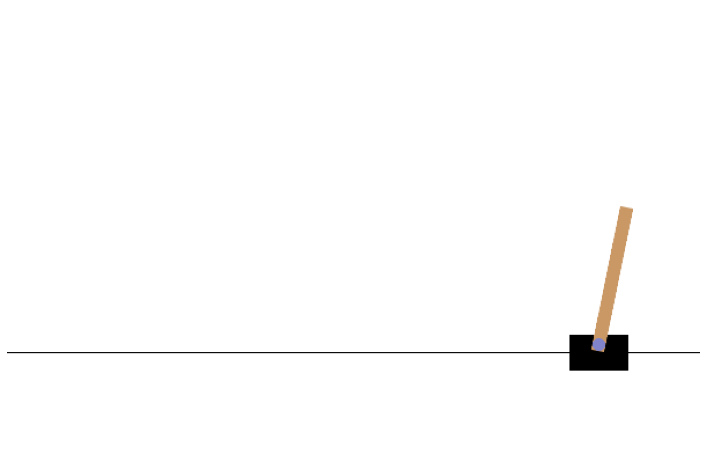

In [32]:
cartpole_env = Environment()
cartpole_env.run_160()

In [34]:
from base64 import b64encode
mp4 = open('movie_cartpole.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=500 controls>
  <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

$ϵ$ ϵ
